# Lets Grow More
## Data Science Internship(Aug-2023)
## Task-Stock price prediction
### TEK CHAND

In [2]:
#Importing libraries

import numpy as np
import pandas as pd

#For data viz
import seaborn as sns
import matplotlib.pyplot as plt

#For creating LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import tensorflow as tf

In [3]:
#Reading the dataset
df=pd.read_csv(r"https://raw.githubusercontent.com/TKSDE/Bharat_Data_Science/main/Q%3A-1/stock_in_xbom_543636.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,08/18/2023,155.0,157.95,150.05,152.70,301
1,08/17/2023,159.9,159.90,152.00,155.50,194
2,08/16/2023,156.5,156.50,147.05,154.95,230
3,08/14/2023,160.0,160.00,152.00,153.80,903
4,08/11/2023,160.0,160.00,160.00,160.00,1


In [4]:
#Checking the null values
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    21 non-null     object 
 1   Open    21 non-null     float64
 2   High    21 non-null     float64
 3   Low     21 non-null     float64
 4   Close   21 non-null     float64
 5   Volume  21 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is stationary.

In [6]:
#Univariate model

In [7]:
df=df[['Date','Close']]
df.Date=pd.to_datetime(df.Date)#For changing the datatype

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    21 non-null     datetime64[ns]
 1   Close   21 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 464.0 bytes


In [9]:
df1=df.reset_index()['Close']

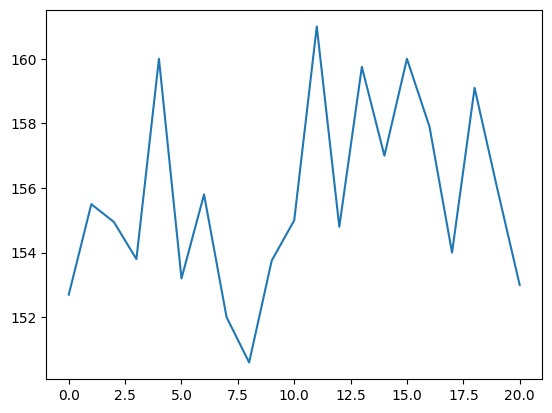

In [10]:
plt.plot(df1)#It is non stationary

In [11]:
from statsmodels.tsa.stattools import adfuller

#Since we are using LSTM model no need of stationary data,if timeseries is tdone by arima model then need to make the stationary data as here p value is less than 0.05 so reject the null hypothesis

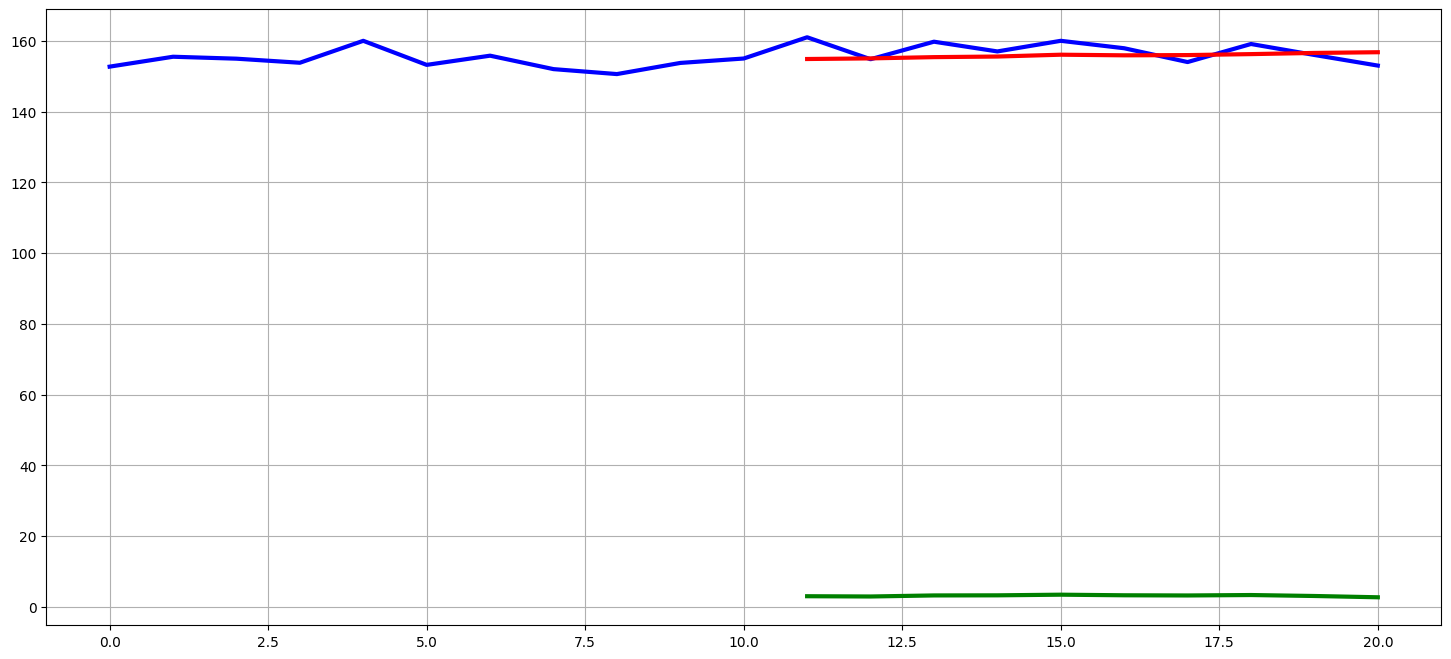

Test Statistics           -3.986706
p-value                    0.001482
No of lags                 0.000000
No of observation used    20.000000
critical value (1%)       -3.809209
critical value (5%)       -3.021645
critical value (10%)      -2.650713
dtype: float64


In [12]:
#Test for stationary
def test_stationary(timeseries):
    rolemean=timeseries.rolling(12).mean()
    rolestd=timeseries.rolling(12).std()
    plt.figure(figsize=(18,8))
    plt.grid('both')
    plt.plot(timeseries,color='blue',label='Orginal',linewidth=3)
    plt.plot(rolemean,color='red',label='Rolling Mean',linewidth=3)
    plt.plot(rolestd,color='green',label='Rolling Std',linewidth=3)
    plt.show()
    adft=adfuller(timeseries,autolag='AIC')
    output=pd.Series(adft[0:4],index=['Test Statistics','p-value','No of lags','No of observation used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key]=values
    print(output)    
test_stationary(df1)    

In [13]:
#Lets scale the data by using Min Max scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))#Since it contains the single feature,reshape it to have a 2 dim
df1

array([[0.20192308],
       [0.47115385],
       [0.41826923],
       [0.30769231],
       [0.90384615],
       [0.25      ],
       [0.5       ],
       [0.13461538],
       [0.        ],
       [0.30288462],
       [0.42307692],
       [1.        ],
       [0.40384615],
       [0.87980769],
       [0.61538462],
       [0.90384615],
       [0.70192308],
       [0.32692308],
       [0.81730769],
       [0.51923077],
       [0.23076923]])

In [14]:
df1.ndim#Changing the data from 1d to 2d

2

In [15]:
df1.shape

(21, 1)

From the one column itself we are making training and testing data so splitting is done on 70:30 ratio

In [16]:
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size],df[training_size:len(df)]

In [17]:
train_data=df[0:training_size]

In [18]:
train_data

,Date,Close
0,2023-08-18,152.70
1,2023-08-17,155.50
2,2023-08-16,154.95
3,2023-08-14,153.80
4,2023-08-11,160.00
5,2023-08-10,153.20
6,2023-08-09,155.80
7,2023-08-08,152.00
8,2023-08-07,150.60
9,2023-08-04,153.75


In [19]:
training_size,test_size

(14, 7)

In [20]:
#Over here we have created the x train dataset but its stored in list 
x=[]
dataset=train_data
for i in range(len(dataset)-100-1):
    a = dataset[i:(i+100), 0]
    x.append(a)
x

[]

In [21]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [22]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [23]:
X_train

array([], dtype=float64)

In [24]:

#X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)#converting the array into 3d so ( , ,1)
#X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

if X_train.shape[0] != 0 and len(X_train.shape) > 1:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

if X_test.shape[0] != 0 and len(X_test.shape) > 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [25]:
X_train

array([], dtype=float64)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

Sequential-Machine learning models that input or output data sequences are known as sequence models

dense-Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense. Dense Layer is used to classify image based on output from convolutional layers.

In [27]:
#Stacked LSTM with 3 sequential data and then dense
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))#here the batch size is none,so it will take any nimer of batches
model.add(LSTM(50,return_sequences=True))#return_sequences=it will output all the hidden states of each time steps.
model.add(LSTM(50))#50 is nothing but neurons we are passing
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')#This adam optimize the value faster than other optimizer algorithm,its like gradient descent

2023-08-23 08:38:38.190049: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Why epoch need to be used?
Small batches of training data are shown to network, one run of when entire training data is shown to the model in batches and error is calculated is called an epoch. The epochs are to be run ‘til the time the error is reducing.

In [34]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)


Epoch 1/100


ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [35]:
import tensorflow as tf

In [38]:
tf.__version__

'2.13.0'

In [39]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [40]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

NameError: name 'train_predict' is not defined

In [41]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

NameError: name 'train_predict' is not defined

In [42]:
math.sqrt(mean_squared_error(y_test,test_predict))


NameError: name 'test_predict' is not defined

In [43]:
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: name 'train_predict' is not defined

In [44]:
len(test_data)

7

In [45]:
x_input=test_data[511:].reshape(1,-1)
x_input.shape

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [46]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

NameError: name 'x_input' is not defined

In [48]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

NameError: name 'x_input' is not defined